In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_df = pd.read_csv('./archive/cbb.csv')
train_df = train_df[train_df['SEED'] < 17.0]
train_df.reset_index()
test_df = pd.read_csv('./archive/cbb21.csv')
test_df[test_df['SEED'] < 17.0]
test_df.reset_index()
testing_output_df = pd.read_csv('./archive/cbb20.csv')

y_post = np.array(train_df['POSTSEASON'])
y_post = y_post.reshape(len(y_post),1)
cats = np.array(['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68'][::-1])
cats = list(cats.reshape(1,-1))


onehot = OneHotEncoder(categories=cats, sparse=False)

onehot_encode = onehot.fit_transform(y_post)
y_group=np.array([None]*onehot_encode.shape[0])
for i,row in enumerate(onehot_encode):
    idx = list(np.where(row == 1)[0])
   
    if idx[0] < 2.5:
        y_group[i] = 0
    elif idx[0] > 2.5:
        y_group[i] = 1
        
smote = SMOTE()
x_cats = ['TEAM','ADJOE','ADJDE','EFG_O','EFG_D','TOR', 'TORD', 'ORB','FTRD', '2P_D', '3P_O', '3P_D','ADJ_T']
X = train_df[x_cats]
X_test = test_df[x_cats]
# y-test
sweet_16 = ['Gonzaga', 'Creighton', 'USC', 'Oregon', 'Michigan', 'Florida St.','UCLA','Alabama','Baylor','Villanova','Arkansas','Oral Roberts', 'Loyola Chicago', 'Oregon St.', 'Syracuse','Houston']
index_list = []
for t in sweet_16:
    index_list.append(X_test.loc[X_test['TEAM'] == t].index[0])
sweet_g21 = np.zeros(X_test.shape[0])
sweet_g21[index_list] = 1
y_group = y_group.astype(int)
print(type(y_group),type(sweet_g21))
y1 = np.hstack([y_group,sweet_g21])
#print(y1,sweet_g21)
X1 = pd.concat([X,X_test],axis=0)
#X_test=X_test.set_index('TEAM')
X1=X1.set_index('TEAM')
X, y_even = smote.fit_resample(X1,y1)


X.shape
from sklearn.model_selection import KFold
kfold = KFold(n_splits=8) # there are 8 yearts of data, so splitting by year gives the best representative

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Now to try and prove Linear with rbf is best with cross_val_score with linaer SVC and randomforest 

In [3]:
svmr = sklearn.svm.SVC(kernel='rbf')
svml = sklearn.svm.SVC(kernel='linear')
rf = RandomForestClassifier()

In [4]:
pca = PCA(n_components=10)
pca.fit(X)
Xpca = pca.fit_transform(X)
#x_train, x_test, y_train, y_test = train_test_split(X,y_even,test_size=0.1,shuffle=False)

pca.explained_variance_ratio_

array([0.50540037, 0.19167229, 0.11740356, 0.05506896, 0.03943407,
       0.03254362, 0.02036074, 0.01718813, 0.00987964, 0.00736534])

In [5]:
scores =cross_validate(svmr,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.632982905982906 0.6674422995250797


In [6]:
cross_validate(svml,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.632982905982906 0.6674422995250797


In [7]:
cross_validate(rf,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.632982905982906 0.6674422995250797


In [8]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
cross_validate(mlp,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.632982905982906 0.6674422995250797


# Well, this means the type of simple classifier really doesn't matter in this scenario

# Honestly though, this is encouraging. We even see I slight deprecation in the model's efficiency when we add more complex model types. A linear classifier seems to perform the best

# Occams Razor


## To-do: plot the approximate decision boundary in 2D in each PCA plot

In [110]:
def pca_subplots(Xpca1,Xpca2,y1,y2,labels):
    
    fig1=plt.figure(figsize=(8,8))

    scat1 = plt.scatter(Xpca1[:,0],Xpca1[:,1],c=y1,cmap='winter')
    plt.xlim([-20,40])
    plt.ylim([-20,20])
    plt.xlabel('PCA Component 1',fontsize=18)
    plt.ylabel('PCA Component 2', fontsize=18)
    plt.title(' Top 68 Tournament teams in PCA-Space', fontsize=20)
    plt.legend(handles=scat1.legend_elements()[0],labels = labels)
    plt.tight_layout()
    fig1.show()
    fig2=plt.figure(figsize=(8,8))
    scat2 = plt.scatter(Xpca2[:,0],Xpca2[:,1],c=y2,cmap='winter')
    plt.xlim([-20,40])
    plt.ylim([-20,20])
    plt.xlabel('PCA Component 1',fontsize=18)
    plt.ylabel('PCA Component 2', fontsize=18)
    plt.title('Random Tournament teams in PCA-Space', fontsize=20)
    plt.legend(handles=scat2.legend_elements()[0],labels = labels)
    plt.tight_layout()
    fig2.show()
    plt.show()

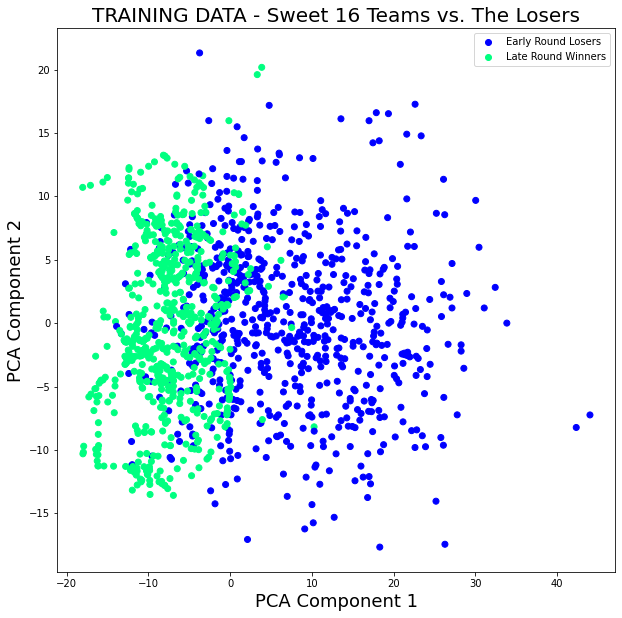

In [126]:
fig=plt.figure(figsize=(10,10))
scat = plt.scatter(Xpca[:,0],Xpca[:,1],c=y_even,cmap='winter')
plt.xlabel('PCA Component 1',fontsize=18)
plt.ylabel('PCA Component 2', fontsize=18)
plt.title('TRAINING DATA - Sweet 16 Teams vs. The Losers', fontsize=20)
plt.legend(handles=scat.legend_elements()[0],labels = ['Early Round Losers', 'Late Round Winners'])
plt.savefig('pca2d_trainingdata.png')
plt.show()

# In the graph above, we see that in two PCA dimensions (paricularly PCA1), there is a somewhat clear linear classifier, something that a SVC could do. In the codes scattered in the GitHub repo, I tested to see if I couldn't accomplish a simpler task of potentially trying to classify a high-probability sweet 16 team versus one that might have a high-probability of losing before that

## We've identified two sets of training data, one year 13-19 and 21, class imbalanced, and class balanced

## Below we try and test on 2020 Data available to see, and try to get a reasonable output that i can understand (namely, team names)

### Because today is selection sunday 20222!

In [111]:
output_df = testing_output_df[x_cats]
test_20_df = output_df.iloc[0:68]
test_20_rand = output_df.sample(n=68,random_state=42,replace=False)
test_20_df = test_20_df.set_index('TEAM')
test_20_rand = test_20_rand.set_index('TEAM')
test_20_rand.tail()
#output_df.iloc[0:32]

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
Georgetown,110.2,100.1,49.1,50.8,18.9,18.8,32.5,26.6,48.1,34.6,36.4,70.1
Rhode Island,104.7,94.4,46.9,47.4,16.4,20.9,30.4,28.5,49.1,31.5,29.7,71.2
Fairleigh Dickinson,101.8,112.4,51.1,52.5,18.5,18.0,26.5,31.9,52.8,35.7,34.7,68.5
Milwaukee,96.1,104.4,46.8,50.8,18.8,20.8,29.2,43.8,49.6,31.7,35.3,69.4
Coastal Carolina,104.4,106.5,50.1,50.0,21.9,18.4,35.9,45.8,49.7,33.1,33.6,72.5


# now, we take our fitted pca to transform this 2020 data. For simple testing at first, one the top 68 team in the data set (expecting maybe 32 positives) and a random 68 (expect less, hopefully)

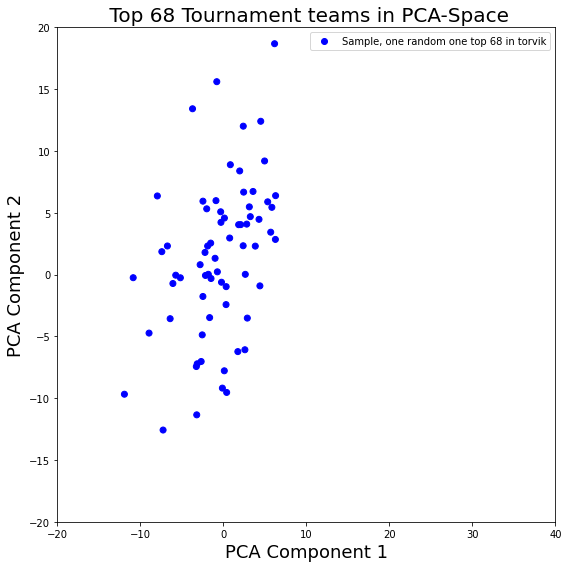

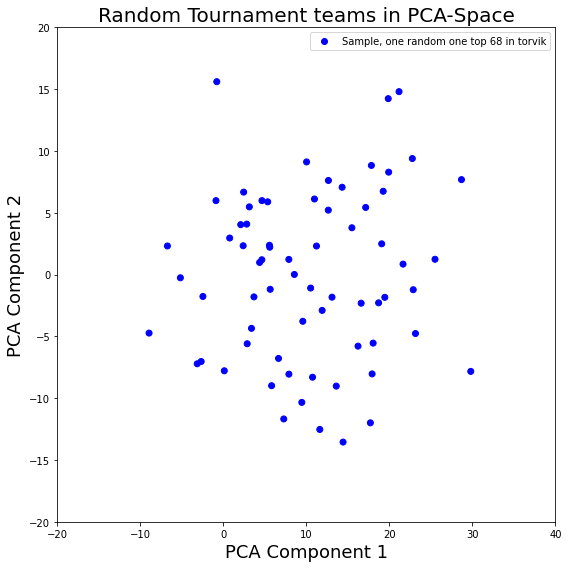

In [95]:
testpca_20_df = pca.transform(test_20_df)
testpca_20_rand = pca.transform(test_20_rand)
pca_subplots(testpca_20_df,testpca_20_rand,[0]*68,[1]*68,['Sample, one random one top 68 in torvik'])

# We see these two set should be pretty decent 

## Now try and fit and predict

In [112]:
def model_subplots(Xpca1,Xpca2,y1,y2,labels,tits):
    
    fig1=plt.figure(figsize=(8,8))

    scat1 = plt.scatter(Xpca1[:,0],Xpca1[:,1],c=y1,cmap='winter')
    plt.xlim([-20,40])
    plt.ylim([-20,20])
    plt.xlabel('PCA Component 1',fontsize=18)
    plt.ylabel('PCA Component 2',fontsize=18)
    plt.title(tits + ' Top 68 Sample', fontsize=20)
    plt.legend(handles=scat1.legend_elements()[0],labels = labels)
    plt.tight_layout()
    fig1.show()
    fig2=plt.figure(figsize=(8,8))
    scat2 = plt.scatter(Xpca2[:,0],Xpca2[:,1],c=y2,cmap='winter')
    plt.xlim([-20,40])
    plt.ylim([-20,20])
    plt.xlabel('PCA Component 1',fontsize=18)
    plt.ylabel('PCA Component 2', fontsize=18)
    plt.title(tits+' Random Sample', fontsize=20)
    plt.legend(handles=scat2.legend_elements()[0],labels = labels)
    plt.tight_layout()
    fig2.show()
    plt.show()

In [113]:
def precision_recall(y_test, predicted_y):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    return precision_score, recall_score

# Thiese are the two models I am testing, on rbf and one RF

## based on recall --> TP / (TP + FN) What % of the real trues did you get and precision --> TP / (TP + FP

## Both got similar precision and recall - showing p & r for SVC and F1 score for RF

In [114]:
svm = sklearn.svm.SVC(kernel='rbf')
y_even = y_even.astype(int)
scores = cross_validate(svm,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_recall']), np.mean(scores['test_precision']))

0.6674422995250797 0.632982905982906


In [115]:
rf = RandomForestClassifier()
y_even = y_even.astype(int)
scores = cross_validate(rf,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
m = np.mean(scores['test_recall'])
print(2*(np.mean(scores['test_recall']) * np.mean(scores['test_precision'])) / (np.mean(scores['test_recall']) + np.mean(scores['test_precision'])))

0.665551424221028


In [116]:
svm.fit(Xpca[:,0:3],y_even)
preds_t =svm.predict(testpca_20_df[:,0:3])
preds_r = svm.predict(testpca_20_rand[:,0:3])

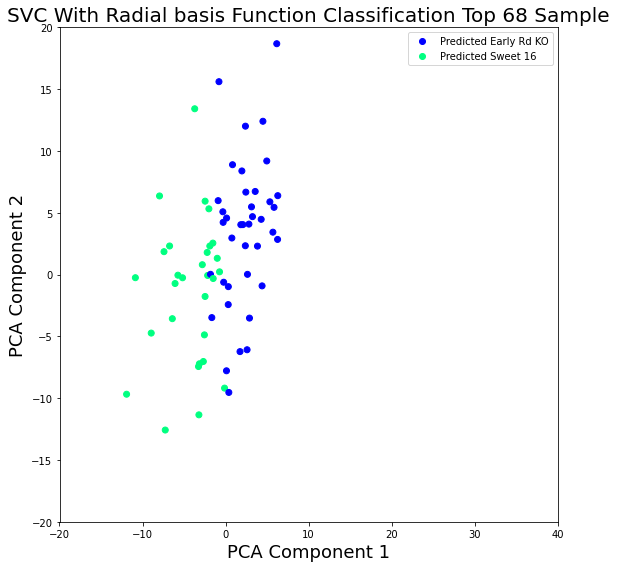

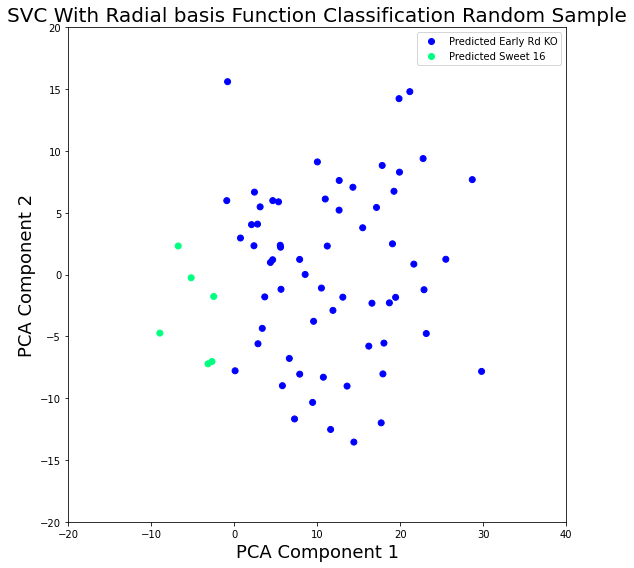

 Number of sweet 16 preds with top 68: 29
25


,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
Kansas,116.1,87.7,53.7,43.7,18.7,18.6,32.6,23.2,42.4,34.1,30.5,67.4
Baylor,114.5,88.4,49.4,45.2,17.8,22.7,35.8,30.8,44.4,35.1,31.1,66.2
Gonzaga,121.3,94.3,57.5,47.6,15.3,18.4,33.6,21.8,47.4,38.6,32.0,72.0
Dayton,119.5,93.4,59.7,46.6,18.0,18.8,26.4,30.9,45.1,37.1,33.0,67.5
Michigan St.,114.8,91.3,52.6,43.3,18.1,15.8,32.8,29.3,43.4,34.8,28.7,69.3
Duke,115.3,91.9,52.6,45.7,17.8,20.2,34.8,30.9,46.0,35.2,29.9,71.7
Creighton,120.6,96.4,55.2,48.4,15.9,17.6,23.9,23.4,48.9,38.7,31.8,68.3
Ohio St.,114.6,92.6,52.3,46.2,19.1,18.3,31.1,29.3,44.2,37.3,32.7,66.2
Louisville,115.1,93.9,52.5,45.1,18.0,17.4,32.0,29.0,45.1,37.6,30.1,66.9


In [117]:
labels = ['Predicted Early Rd KO', 'Predicted Sweet 16']
model_subplots(testpca_20_df,testpca_20_rand,preds_t,preds_r,labels=labels,tits='SVC With Radial basis Function Classification')
idx = np.where(preds_t==1)
nid = np.where(preds_t==0)
s16 = []
count = 0
for i in idx[0]:
    s16.append(test_20_df.iloc[i])
print(' Number of sweet 16 preds with top 68: ' + str(len(s16)))
# 27 positive preds
print(np.sum(preds_t[0:32]))
test_20_df.iloc[idx[0]]

In [118]:
# the 25/32 meants it definitely selected higher-stats teams, yet it does have some kind of discernment.

# the 29 from the true set is expected, as that data is an all at-large bid league
# the random - 68 teams / 360 teams total --> about 1/8 of them should be

In [119]:
idx = np.where(preds_r==1)
nid = np.where(preds_r==0)
s16 = []
count = 0
for i in idx[0]:
    s16.append(test_20_df.iloc[i])
print(' Number of sweet 16 preds with Random ' + str(len(s16)))

test_20_rand.iloc[idx[0]]

 Number of sweet 16 preds with Random 6


,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
LSU,118.2,102.5,52.7,49.4,17.6,16.6,35.1,26.4,47.8,32.7,34.5,69.9
Maryland,112.6,94.7,48.6,46.1,16.7,17.3,31.5,24.2,44.5,31.1,32.5,67.1
San Diego St.,113.8,92.8,54.6,45.2,16.2,21.3,28.2,30.6,45.3,37.9,30.1,64.7
Iowa,117.2,99.7,51.6,49.4,17.1,17.6,32.0,26.8,50.3,34.7,32.1,70.1
Duke,115.3,91.9,52.6,45.7,17.8,20.2,34.8,30.9,46.0,35.2,29.9,71.7
Dayton,119.5,93.4,59.7,46.6,18.0,18.8,26.4,30.9,45.1,37.1,33.0,67.5


# This is astounding. This does seem to select teams that are linearly selected i'n PCA space!

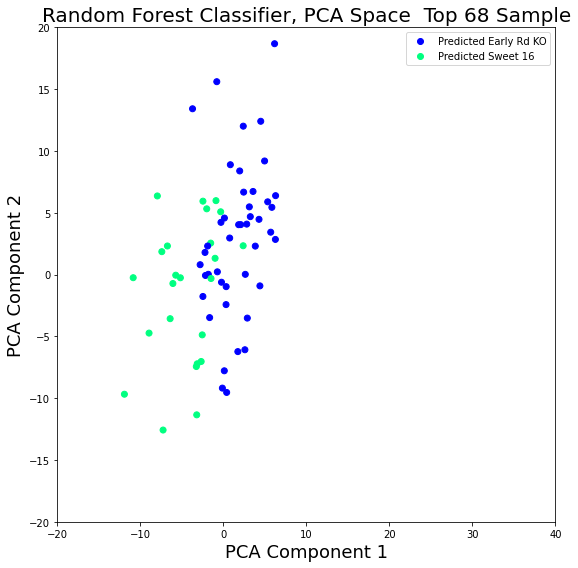

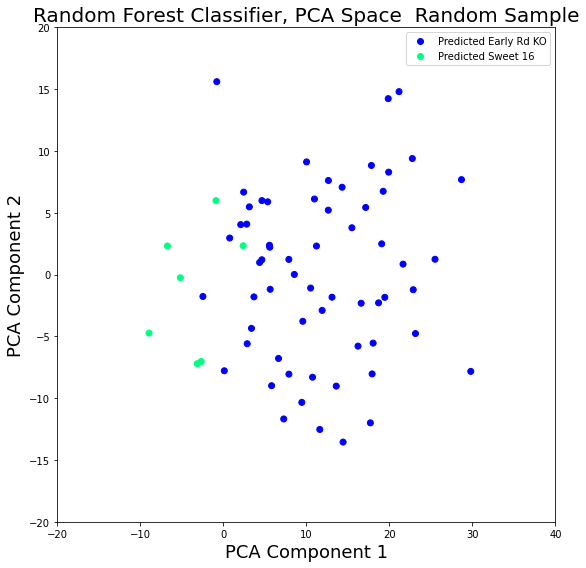

In [124]:
rf.fit(Xpca[:,0:3],y_even)
predr_t = rf.predict(testpca_20_df[:,0:3])
predr_r = rf.predict(testpca_20_rand[:,0:3])
model_subplots(testpca_20_df,testpca_20_rand,predr_t,predr_r,labels=labels,tits='Random Forest Classifier, PCA Space ')

In [122]:
idx = np.where(predr_t==1)
s16 = []
count = 0
for i in idx[0]:
    s16.append(test_20_df.iloc[i])
print(' Number fo sweet 16 preds: ' + str(len(s16)))
# 27 positive preds
test_20_df.iloc[idx[0]]

 Number fo sweet 16 preds: 25


,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
Kansas,116.1,87.7,53.7,43.7,18.7,18.6,32.6,23.2,42.4,34.1,30.5,67.4
Baylor,114.5,88.4,49.4,45.2,17.8,22.7,35.8,30.8,44.4,35.1,31.1,66.2
Gonzaga,121.3,94.3,57.5,47.6,15.3,18.4,33.6,21.8,47.4,38.6,32.0,72.0
Dayton,119.5,93.4,59.7,46.6,18.0,18.8,26.4,30.9,45.1,37.1,33.0,67.5
Michigan St.,114.8,91.3,52.6,43.3,18.1,15.8,32.8,29.3,43.4,34.8,28.7,69.3
Duke,115.3,91.9,52.6,45.7,17.8,20.2,34.8,30.9,46.0,35.2,29.9,71.7
Creighton,120.6,96.4,55.2,48.4,15.9,17.6,23.9,23.4,48.9,38.7,31.8,68.3
Ohio St.,114.6,92.6,52.3,46.2,19.1,18.3,31.1,29.3,44.2,37.3,32.7,66.2
Louisville,115.1,93.9,52.5,45.1,18.0,17.4,32.0,29.0,45.1,37.6,30.1,66.9


In [123]:
idx = np.where(predr_r==1)
nid = np.where(predr_r==0)
s16 = []
count = 0
for i in idx[0]:
    s16.append(test_20_df.iloc[i])
print(' Number of sweet 16 preds with Random ' + str(len(s16)))

test_20_rand.iloc[idx[0]]

 Number of sweet 16 preds with Random 8


,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
LSU,118.2,102.5,52.7,49.4,17.6,16.6,35.1,26.4,47.8,32.7,34.5,69.9
Maryland,112.6,94.7,48.6,46.1,16.7,17.3,31.5,24.2,44.5,31.1,32.5,67.1
San Diego St.,113.8,92.8,54.6,45.2,16.2,21.3,28.2,30.6,45.3,37.9,30.1,64.7
Purdue,109.6,91.6,47.8,47.1,17.4,20.4,34.9,31.9,48.1,33.0,30.5,64.3
Iowa,117.2,99.7,51.6,49.4,17.1,17.6,32.0,26.8,50.3,34.7,32.1,70.1
Duke,115.3,91.9,52.6,45.7,17.8,20.2,34.8,30.9,46.0,35.2,29.9,71.7
North Carolina St.,110.6,96.5,50.8,47.8,16.9,20.1,28.8,35.4,48.0,31.8,31.6,69.5
Dayton,119.5,93.4,59.7,46.6,18.0,18.8,26.4,30.9,45.1,37.1,33.0,67.5


# Above test is just to show it works, and that both models provide variation in their outputs

# the random will be the true sign

In [ ]:
preds_r = svm.predict(testpca_20_rand[:,0:3])
predr_r = rf.predict(testpca_20_rand[:,0:3])

In [ ]:
model_suplots(testpcatestpca_20_rand,preds_r,['Losers', 'Winners'])
pca_plot(testpca_20_rand,predr_r,['Losers', 'Winners'])

In [ ]:
idx = np.where(predr_r==1)
print(test_20_rand.iloc[idx[0]])
idx = np.where(preds_r==1)
print(test_20_rand.iloc[idx[0]])

# These models are performing exactly as they sohlud given the input data - again very promising for the utility of the Torvk stats in predicting sweet 16 teams
